In [1]:
import os, sys
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir,'..')))

In [2]:
import yfinance as yf
import pandas as pd

# Fetch TSLA data
tsla_data = yf.download("TSLA", start="2015-01-01", end="2025-01-31")
tsla_data = tsla_data[['Close']]  # Use only the 'Close' price for forecasting
tsla_data.dropna(inplace=True)  # Drop any remaining missing values

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Split the data
train_size = int(len(tsla_data) * 0.8)
train, test = tsla_data.iloc[:train_size], tsla_data.iloc[train_size:]

print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")

Training set size: 2028
Testing set size: 507


LSTM Model

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Create sequences for LSTM
def create_sequences(data, timesteps=60):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

timesteps = 60  # Use 60 days of historical data to predict the next day
X_train, y_train = create_sequences(train_scaled, timesteps)
X_test, y_test = create_sequences(test_scaled, timesteps)

# Reshape data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

c:\Users\USER\Documents\10X_Exercises\Week-11-GMF\.env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0144 - val_loss: 0.0034
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.3818e-04 - val_loss: 0.0022
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.3837e-04 - val_loss: 0.0020
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.9490e-04 - val_loss: 0.0041
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 8.1099e-04 - val_loss: 0.0017
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 6.1098e-04 - val_loss: 0.0017
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 5.4531e-04 - val_loss: 0.0018
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 6.3424e-04 - val_loss: 0.0018
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 6.4467e-04 - val_loss: 0.0013
Epoch 12/20
62/62 ━━━━━━━━━━━━━

In [8]:
# Predict on the test set
from sklearn.metrics import mean_absolute_error, mean_squared_error


predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to original scale

# Evaluate the model
mae = mean_absolute_error(test[timesteps:], predictions)
rmse = np.sqrt(mean_squared_error(test[timesteps:], predictions))
mape = np.mean(np.abs((test[timesteps:].values - predictions) / test[timesteps:].values)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 8.294300079345703
RMSE: 11.895163032277159
MAPE: 3.379934301518199%


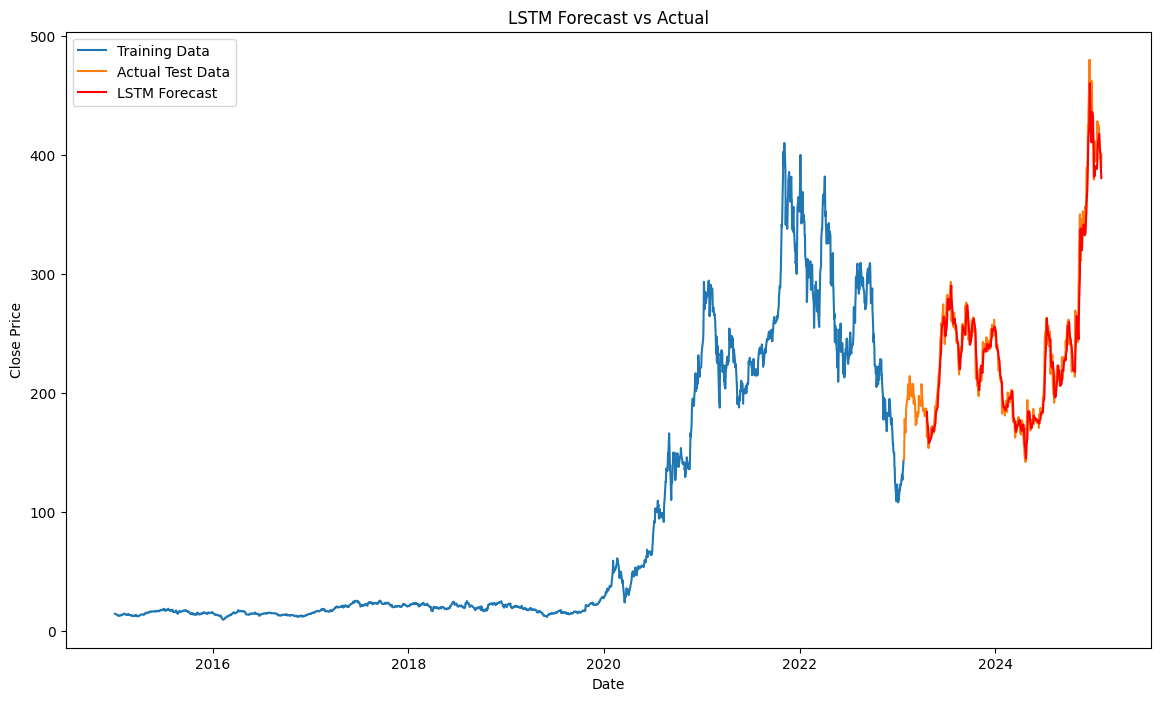

In [9]:
from matplotlib import pyplot as plt


plt.figure(figsize=(14, 8))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index[timesteps:], predictions, label='LSTM Forecast', color='red')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [10]:
# Save the entire LSTM model (architecture, weights, and optimizer state)
model.save('../model/lstm_model.h5')